In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
import keras
import keras.layers as layers
import keras.backend as KB
from itertools import product
import sys
import math

In [2]:
from sparsegrid_network import *

In [3]:
# make example

n_samples = 2500
noise = 1e-3

n_layers = 2
n_dim_per_layer = 20

LEARNING_RATE = 0.002#5e-2
ACTIVATION = tf.nn.elu
N_EPOCHS = 100

random_state = 1

#n_sg_basis_functions=50
n_fg_basis_functions_per_dim= 10
level = 5 # sparse grid level


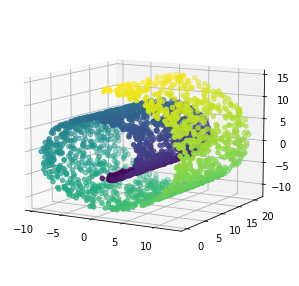

In [4]:
from sklearn.datasets import make_s_curve, make_swiss_roll

data_in, data_out = make_swiss_roll(n_samples=n_samples, noise=noise)

data_out = data_out.reshape(-1,1)

n_input_dimensions = data_in.shape[1]
n_latent_dimensions = 2 # how many latent dimensions do we want? I.e. where should the network map to...
n_output_dimensions = data_out.shape[1]
level_vec_fg = np.ones(n_latent_dimensions, dtype=int) * n_fg_basis_functions_per_dim

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection="3d")
ax.scatter(*data_in.T, c=data_out)
ax.view_init(10,-60)

# test the "sparse grid"
rng = np.random.default_rng(random_state)

#positions = np.sort(0+1*rng.uniform(low=-.5, high=.5,
#                        size=(n_sg_basis_functions, n_latent_dimensions)), axis=0)


# random scales per basis function
#scales = 1+1e-1*rng.uniform(low=1, high=10,
#                        size=(n_sg_basis_functions, 1)) # only use a single scale per function, not in each dimension


#print(positions, scales)

#print('positions', positions.shape)
#print('scales', scales.shape)
level = 5 # sparse grid level

combi_scheme = [level_vector for level_vector in product(*[list(range(1,level+1)) for d in range(n_latent_dimensions)]) if level <= sum(level_vector) <= level + n_latent_dimensions - 1]
combi_coefficients = []
dim = n_latent_dimensions
for level_vector in combi_scheme:
    q = (level + n_latent_dimensions - 1 - sum(level_vector))
    coefficient = (-1)**q * math.factorial(dim-1)/(math.factorial(q)*math.factorial(dim-1-q))
    combi_coefficients.append(int(coefficient))
    print(level_vector, coefficient)
component_grids = []
combi_scheme = [(5,5)]
combi_coefficients = [1]
for grid in combi_scheme:
    level_vec_combi_grid = 2**(np.asarray(grid)) - 1
    positions = np.asarray(list(product(*[np.linspace(0,1,level_vec_combi_grid[d] + 1)[1:] for d in range(dim) ])))
    scales = np.ones((len(positions),dim)) * 1/(level_vec_combi_grid+1)
    sgt = SparseGridTest(positions, scales)
    component_grids.append(sgt)
    print(positions.shape)
    print(scales.shape)
    x = np.asarray(list(product(*[np.linspace(0,1,20 + 1)[1:] for d in range(dim)])))
    y = np.array(KB.eval(sgt.kernel(x)))
    plt.matshow(y.T)


(1, 4) -1.0
(1, 5) 1.0
(2, 3) -1.0
(2, 4) 1.0
(3, 2) -1.0
(3, 3) 1.0
(4, 1) -1.0
(4, 2) 1.0
(5, 1) 1.0
(273, 2) (273, 2)
(273, 2)
(273, 2)


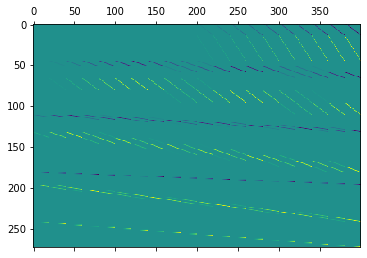

In [16]:
# test the "sparse grid"
rng = np.random.default_rng(random_state)

#positions = np.sort(0+1*rng.uniform(low=-.5, high=.5,
#                        size=(n_sg_basis_functions, n_latent_dimensions)), axis=0)


# random scales per basis function
#scales = 1+1e-1*rng.uniform(low=1, high=10,
#                        size=(n_sg_basis_functions, 1)) # only use a single scale per function, not in each dimension


#print(positions, scales)

#print('positions', positions.shape)
#print('scales', scales.shape)

combi_scheme = [level_vector for level_vector in product(*[list(range(1,level+1)) for d in range(n_latent_dimensions)]) if level <= sum(level_vector) <= level + n_latent_dimensions - 1]
combi_coefficients = []
dim = n_latent_dimensions
for level_vector in combi_scheme:
    q = (level + n_latent_dimensions - 1 - sum(level_vector))
    coefficient = (-1)**q * math.factorial(dim-1)/(math.factorial(q)*math.factorial(dim-1-q))
    combi_coefficients.append(int(coefficient))
    print(level_vector, coefficient)
#combi_scheme = [(5,5)]
#coefficients = [1]
positions = np.array([]).reshape(0,dim)
scales = np.array([]).reshape(0,dim)
coefficients = np.array([], dtype=int)
for grid, coefficient in zip(combi_scheme, combi_coefficients):
    level_vec_combi_grid = 2**(np.asarray(grid)) - 1

    num_points_grid = np.prod(level_vec_combi_grid)
    positions = np.concatenate((positions,np.asarray(list(product(*[np.linspace(0,1,level_vec_combi_grid[d] + 1)[1:] for d in range(dim) ])))))
    scales = np.concatenate((scales,np.ones((num_points_grid,dim)) * 1/(level_vec_combi_grid+1)))
    coefficients = np.concatenate((coefficients, np.ones(num_points_grid) * coefficient))
print(positions.shape, scales.shape)
sgt = CombiGridTest(positions, scales, coefficients)

print(positions.shape)
print(scales.shape)
x = np.asarray(list(product(*[np.linspace(0,1,20 + 1)[1:] for d in range(dim)])))
y = np.array(KB.eval(sgt.kernel(x)))
plt.matshow(y.T)


(2500, 2)
sg kernel shape (2500, 273)


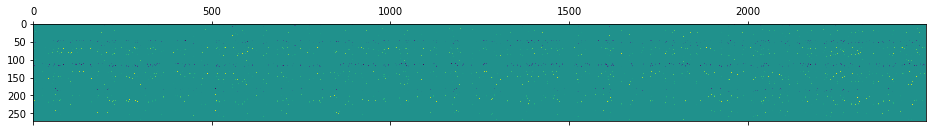

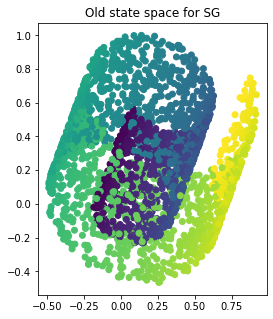

In [6]:
# construct network

model = ModelBuilder.define_encoder_model(n_input_dimensions=n_input_dimensions,
                                          n_latent_dimensions=n_latent_dimensions,
                                           n_layers=n_layers,
                                           n_dim_per_layer=n_dim_per_layer,
                                           name="sgnet", activation=ACTIVATION, last_activation=tf.nn.tanh)

sgn = SparseGridNetwork(encoder=model,
                        sparse_grids=[sgt], coefficients=combi_coefficients, l2_regularizer=1e-6,
                        dim_data_in=n_input_dimensions, dim_data_out = n_output_dimensions)
sgn.compute_data_scaler(data_in)
sgn.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

print(model(data_in).shape)

# here, we just project onto the two (here: random) coordinates, which of course is not the best "dimension reduction" technique...
rng = np.random.default_rng(random_state+12) # here we search for one that at least is somewhat reasonable
U = rng.normal(loc=0, scale=1, size=(3,3))
u,_,v = np.linalg.svd(U)
U = (u@v)[:,:2]

sg_state_space = data_in @ U
sg_state_space /= np.max(sg_state_space)

sg_mat = np.array(KB.eval(sgt.kernel(sg_state_space)))

print("sg kernel shape", sg_mat.shape)
plt.matshow(sg_mat.T)

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(*sg_state_space.T, c=data_out)
ax.set_title("Old state space for SG");

(2500, 1)
(2500, 273)
(273, 1)
error 366.03051954350167


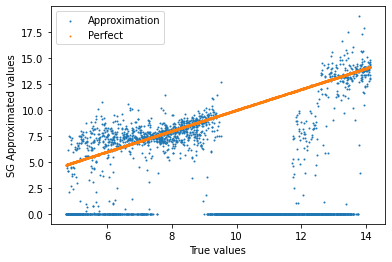

In [7]:
print(data_out.shape)
print(sg_mat.shape)
A = np.linalg.lstsq(sg_mat, data_out, rcond=1e-6)[0]
print(A.shape)

data_approx_sg = sg_mat @ A
print("error", np.linalg.norm(data_approx_sg - data_out))

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.scatter(data_out, data_approx_sg, s=1, label="Approximation")
ax.scatter(data_out, data_out, s=1, label="Perfect")
ax.legend()
ax.set_xlabel("True values")
ax.set_ylabel("SG Approximated values")
ax.legend();

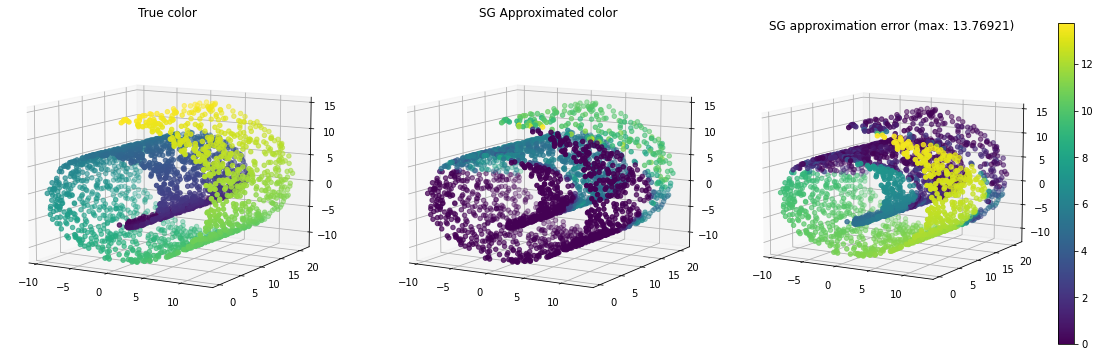

In [8]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,3,1, projection="3d")
ax.scatter(*data_in.T, c=data_out)
ax.view_init(10,-60)
ax.set_title("True color")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.scatter(*data_in.T, c=data_approx_sg)
ax.view_init(10,-60)
ax.set_title("SG Approximated color")

error_sg = np.abs(data_out-data_approx_sg)

ax = fig.add_subplot(1,3,3, projection="3d")
sc1=ax.scatter(*data_in.T, c=error_sg, vmin=0, vmax=np.max(error_sg))
ax.view_init(10,-60)
ax.set_title("SG approximation error (max: {:2.5f})".format(np.max(error_sg)))
fig.colorbar(sc1)

fig.tight_layout()

In [9]:
hist = sgn.train(data_in, data_out, epochs=N_EPOCHS, batch_size=512).history

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
The average loss for epoch 99 is    0.00 

In [10]:
_inputs_scaled = sgn.data_scaler(data_in)
_sg_coeff = sgn.sparse_grids[0].compute_coefficients(sgn.encoder(_inputs_scaled), data_out);
_sg_coeff = KB.eval(_sg_coeff)

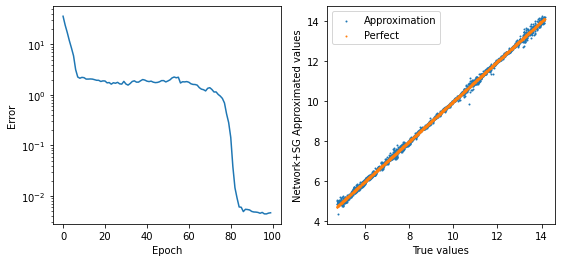

In [11]:
fig,ax = plt.subplots(1,2,figsize=(9,4))
ax[0].semilogy(hist['loss']);
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Error")

data_approx_snet= sgn.call_forward_pass(data_in)

#print(_sg_coeff.shape)

ax[1].scatter(data_out, data_approx_snet, s=1, label="Approximation")
ax[1].scatter(data_out, data_out, s=1, label="Perfect")
ax[1].legend()
ax[1].set_xlabel("True values")
ax[1].set_ylabel("Network+SG Approximated values")
ax[1].legend();

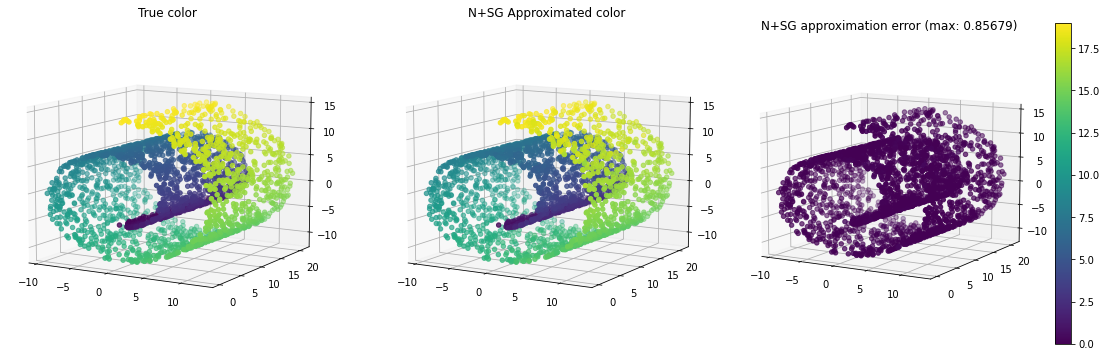

In [12]:

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,3,1, projection="3d")
ax.scatter(*data_in.T, c=data_out)
ax.view_init(10,-60)
ax.set_title("True color")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.scatter(*data_in.T, c=data_approx_snet)
ax.view_init(10,-60)
ax.set_title("N+SG Approximated color")

error_snet = np.abs(data_out-data_approx_snet)

ax = fig.add_subplot(1,3,3, projection="3d")
sc1=ax.scatter(*data_in.T, c=error_snet, vmin=0, vmax=np.max([data_approx_snet, data_approx_sg]))
ax.view_init(10,-60)
ax.set_title("N+SG approximation error (max: {:2.5f})".format(np.max(error_snet)))
fig.colorbar(sc1)

fig.tight_layout()

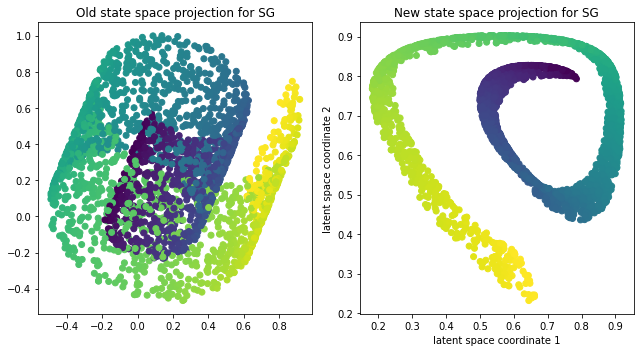

In [13]:
# visualize the new state space (i.e. after the encoder network)

new_states = KB.eval(model(sgn.data_scaler(data_in)))

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(*sg_state_space.T, c=data_out)
ax.set_title("Old state space projection for SG");

ax = fig.add_subplot(1,2,2)
ax.scatter(*new_states.T, c=data_out)
ax.set_xlabel("latent space coordinate 1")
ax.set_ylabel("latent space coordinate 2")
ax.set_title("New state space projection for SG");

fig.tight_layout()